# RECS Survey and Replicate Weights
*Work produced by Stephen Toner*

In [2]:
import os.path as os
import pandas as pd
import scipy.stats as stats
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

This analysis uses data from the Residential Energy Consumption Survey (RECS) 2009 and 2015 survey
data which we will be analyzing can be downloaded here:
* [2009 Data][1] 
* [2009 Replicate Weights][2]
* [2015 Data][3]

[1]: https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv
[2]: https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv
[3]: https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv

We wish to estimate the average number of heating and cooling
degree days for residences by census region for 2009 and 2015.
For reference, a heating or cooling degree day is a measure of how much 
colder or hotter, respectively, the ambient temperature is than the
threshold temperature for comfort, in this case $65 ^\circ F$. As an example,
if the temperature outside is $45 ^\circ F$, on a given day, this would 
be recorded as 20 heating degree days.

In order to conduct our estimate (and provide appropriate confidence
intervals), we will need the following variables from the RECS data:
* DOEID: Department of Energy Identification Number, a unique key for each
household surveyed
* REGIONC: Census region of the household 
* HDD65: The number of heating degree days for the survey year
* CDD65: The number of cooling degree days for the survey year
* NWEIGHT: The final survey weight for each household in the sample; this
corresponds with the number of other similar households a household in the 
survey sample represents
In addition, we will also need to make use of the replicate weights to 
estimate the standard error as the RECS survey uses the balanced repeated
replication ([BRR][4]) technique. These weights are included in the 2015
RECS survey microdata file, but are held in a separate file for the 2009 
survey.
[4]: https://en.wikipedia.org/wiki/Balanced_repeated_replication

A more detailed explanation of the BRR technique used in the RECS survey, 
Fay's method, can be found [here][5]. However, the essence of Fay's method
is to use a series of different sampling weights for each observation
(the replicate weights) to create an estimate of 
population parameter of interest, $\sigma \hat (\theta \hat)$, the standard 
error of the average HDD and CDD for each census region. The formula is:
$$ \hat{\sigma} (\hat{\theta}) = 
\sqrt{\frac{1}{R(1-\epsilon)^2}\sum_{r=1}^R (\hat{\theta} 
r - \hat{\theta})^2} $$

Where:
* $\hat{\sigma}$ is the estimate of the standard error
* $\hat{\theta}$ is the estimate of the population mean
* $R$ is the total number of replicate weights ($244$ for 2009 and $96$
for 2015)
* $\epsilon$ is the Fay coefficeint between $[0,1)$ and equal to $0.5$ in 
the RECS survey
* $r$ is a given BRR replicate weight
[5]: https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf  

# Data Prep
We begin by saving the urls for the data sets into variables, and if the
.csv files do not already exist in our working directory, we download them
and save them:

In [3]:
url_09 = ("https://www.eia.gov/consumption/residential" +
         "/data/2009/csv/recs2009_public.csv")
url_weights_09 = ("https://www.eia.gov/consumption/" +
                 "residential/data/2009/csv/recs2009_public_repweights.csv")
url_15 = ("https://www.eia.gov/consumption/residential"+
          "/data/2015/csv/recs2015_public_v4.csv")

# Save Vars for Later
file_dict = { 
        "recs2009_public.csv" : url_09,
        "recs2009_public_repweights.csv"  : url_weights_09,
        "recs2015_public_v4.csv" : url_15
        }

for x in file_dict.keys(): 
    if not os.exists(x): 
        pd.read_csv(file_dict[x]).to_csv(x)

/opt/homebrew/Caskroom/miniforge/base/envs/507c/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We are now ready to load the variables into memory and manipulate them with
Python. We only want to keep the variables that we will actually use, but
first we need to generate labels for the replicate weights and extract them
from the 2015 data set (2009 replicate weights are already separate).

In [4]:
brrwt = "BRRWT" # Label convention for 2015 data
brr_wt = "brr_weight_" # Label convention for 2009 data
wt_labels09 = ["DOEID"] # We need to be able to match the brr to given DOEID
wt_labels15 = ["DOEID"]

for i in range(1, 97): # 2015 has 96 brr
    wt_labels15.append(brrwt + str(i))

for i in range(1, 245): # 2009 has 244 brr
    wt_labels09.append(brr_wt + str(i))

**1(a)** \
    Now we can finally load the data into memory, and only select the
columns desired via Pandas' column subsetting functionality. While we're at
it, we will also convert `DOEID` and `REGIONC` into categorical variables; 
the rest will remain as the default float-like numeric type.

In [5]:
data_09 = pd.read_csv("recs2009_public.csv", low_memory = False)
wts_09 = pd.read_csv("recs2009_public_repweights.csv", low_memory = False)
data_15 = pd.read_csv("recs2015_public_v4.csv", low_memory = False)
wts_15 = data_15[wt_labels15] # Saving the 2015 weights for later

# Keep only the relevant variables
keep_vars = [
     "DOEID",
     "REGIONC",
     "NWEIGHT",
     "HDD65",
     "CDD65"
    ]

data_09 = data_09[keep_vars]
data_15 = data_15[keep_vars]

# Convert categorical data to appropriate type
data_09["REGIONC"] = pd.Categorical(data_09["REGIONC"])
data_15["REGIONC"] = pd.Categorical(data_15["REGIONC"])
data_09["DOEID"] = pd.Categorical(data_09["DOEID"])
data_15["DOEID"] = pd.Categorical(data_15["DOEID"])

**1(b)** \
    The replicate weights are provided in a somewhat inconvenient format,
with each brr weight having a separate column. We want to convert to a long
format to make it easier to vectorize our procedure.

In [6]:
wts_09_long = (wts_09
               .melt(id_vars = "DOEID", value_vars = wt_labels09[1:245])
               .rename(columns = {"variable" : "wt_name",
                                  "value" : "weight"})
               )

wts_15_long = (wts_15
               .melt(id_vars = "DOEID", value_vars = wt_labels15[1:97])
               .rename(columns = {"variable" : "wt_name",
                                  "value" : "weight"})
               )

# Add the desired variables to the long format, so that we can merge later
wts_09 = pd.merge(wts_09_long, 
                  data_09[["DOEID", "REGIONC", "HDD65", "CDD65"]],
                  on="DOEID",
                  how = "outer")

wts_15 = pd.merge(wts_15_long, 
                  data_15[["DOEID", "REGIONC", "HDD65", "CDD65"]],
                  on="DOEID",
                  how = "outer")

# Construct and Report Estimates

**2(a)** \
    We begin by combining the data sets with the replicate weights so that 
we can calculate the weighted average HDD and CDD and the weighted BRR
terms in one pass:

In [7]:
data_09 = (data_09
           .assign(wt_name = "NWEIGHT", 
                   weight = data_09["NWEIGHT"])
           .drop("NWEIGHT", axis = 1)
           )

data_15 = (data_15
           .assign(wt_name = "NWEIGHT", 
                   weight = data_15["NWEIGHT"])
           .drop("NWEIGHT", axis = 1)
           )

data_09 = pd.merge(data_09, 
                     wts_09, 
                     how = "outer", 
                     on=["DOEID", 
                         "wt_name", 
                         "REGIONC",
                         "HDD65", 
                         "CDD65", 
                         "weight"])

data_15 = pd.merge(data_15, 
                     wts_15, 
                     how = "outer", 
                     on=["DOEID", 
                         "wt_name", 
                         "REGIONC",
                         "HDD65", 
                         "CDD65", 
                         "weight"])

Because we want the point estimate and confidence interval of HDD and
CDD for each of the four census regions, we can make user of the Pandas
`groupby()` function to aggregate by type of weight (NWEIGHT vs. BRR) and
by `REGIONC`. We introduce a helper function to process the data.

In [8]:
def process_recs(x):
    """

    Parameters
    ----------
    x : Pandas Data Frame with "HDD65", "CDD65" columns and "NWEIGHT",
    "brr_*" type columns held under a "weight" column
        Processes a dataframe grouped by type of weight "wt_name" and other
        desired groupings, then applies a weighted average for each type of 
        weight of the "HDD65" and "CDD65" columns, respectively

    Returns
    -------
    Pandas Series Object
        Returns a Pandas Series object for both the heating and cooling degree
        days.

    """
    result = {
        'avg_heat' : (x['HDD65']* x['weight']).sum() / x["weight"].sum(),
        'avg_cool' : (x['CDD65']* x['weight']).sum() / x["weight"].sum(),
        }
    return pd.Series(result)

wavgs_09 = (data_09
            .groupby(["wt_name", "REGIONC"])
            .apply(process_recs))

wavgs_15 = (data_15
            .groupby(["wt_name", "REGIONC"])
            .apply(process_recs))

thetas_09 = wavgs_09.loc["NWEIGHT",:]
thetas_15 = wavgs_15.loc["NWEIGHT",:]
          
thetas_09 = thetas_09.rename(columns = {"avg_heat" : "avg_heat_t", 
                                  "avg_cool" : "avg_cool_t"})
    
thetas_15 = thetas_15.rename(columns = {"avg_heat" : "avg_heat_t", 
                                  "avg_cool" : "avg_cool_t"})

With the point estimates out of the way for both 2009 and 2015, we can move
on to estimating the standard error with the BRR method:

In [9]:
brr_09 = pd.merge(wavgs_09.iloc[4:,:], thetas_09, on="REGIONC")
brr_09["squared_diff_cool"] = (brr_09["avg_cool"] - brr_09["avg_cool_t"])**2
brr_09["squared_diff_heat"] = (brr_09["avg_heat"] - brr_09["avg_heat_t"])**2

brr_15 = pd.merge(wavgs_09.iloc[4:,:], thetas_15, on="REGIONC")
brr_15["squared_diff_cool"] = (brr_15["avg_cool"] - brr_15["avg_cool_t"])**2
brr_15["squared_diff_heat"] = (brr_15["avg_heat"] - brr_15["avg_heat_t"])**2

fay = 0.5

r_09 = 244
r_15 = 96

cf_09 = (1/(r_09*(1-fay)**2))
cf_15 = (1/(r_15*(1-fay)**2))

se_est_09 = (brr_09.groupby("REGIONC")
          .sum()
          .drop(["avg_heat", 
                 "avg_cool", 
                 "avg_cool_t", 
                 "avg_heat_t"],axis = 1)
          .multiply(cf_09)
          .pow(0.5)
          .rename(columns = {"squared_diff_cool" : "std_error_cool",
                             "squared_diff_heat" : "std_error_heat"})
          )

se_est_15 = (brr_15.groupby("REGIONC")
          .sum()
          .drop(["avg_heat", 
                 "avg_cool", 
                 "avg_cool_t", 
                 "avg_heat_t"],axis = 1)
          .multiply(cf_15)
          .pow(0.5)
          .rename(columns = {"squared_diff_cool" : "std_error_cool",
                             "squared_diff_heat" : "std_error_heat"})
          )


stats_09 = pd.merge(thetas_09, se_est_09, on="REGIONC").reset_index()
stats_15 = pd.merge(thetas_15, se_est_15, on="REGIONC").reset_index()

At long last, we are able to consolidate our data into a nicely-formatted
table after we have calculated the 95% confidence interval on our point
estimates of heating and cooling degree days for each region in 2009 
and 2015

In [10]:
def std_est_bounds(u ,se, cl = 0.95, diff = False):
    """
    Constructs a confidence interval estimate based on normal theory

    Parameters
    ----------
    u : float, required
        Point estimate passed as argument
    se : float, required
        Standard Error passed for calulating confidence interval
    cl : float, optional
        DESCRIPTION. The default is 0.95.

    Returns
    -------
    tupel(float)
        A tuple of (lwr bound, upr bound)
    """
    alpha = (1 - cl)/2 # CIs are always two-tailed
    z = stats.norm.ppf(1-alpha)
    
    lower, upper = u - z*se, u + z*se 
    if(not diff): # is this a CI for a difference 
        lower = lower.clip(lower=0) # CDD / HDD can never be negatives
        
    return lower, upper

def prep_table(stats_df, diff):
    """
    Parameters
    ----------
    stats_df : Pandas DataFrame with required fields
        Creates 95% confidence interval, renames labels,
        and reorders columns

    Returns
    -------
    Processed / prepped stats table as Pandas DataFrame

    """
    regions = {1: "Northeast", 2: "Midwest", 3: "South", 4: "West"}

    stats_df["REGIONC"] = stats_df["REGIONC"].map(regions)
    stats_df = stats_df.rename(columns = {"REGIONC" : "Region"})
    stats_df.set_index("Region")
    
    heat_bounds = std_est_bounds(stats_df["avg_heat_t"],
                             stats_df["std_error_heat"],
                             diff=diff)
    cool_bounds = std_est_bounds(stats_df["avg_cool_t"], 
                             stats_df["std_error_cool"],
                             diff=diff)
    
    stats_df["heat_lwr"], stats_df["heat_upr"] = heat_bounds
    stats_df["cool_lwr"], stats_df["cool_upr"] = cool_bounds

    ordered_cols = ["Region",
                "avg_heat_t", 
                "std_error_heat", 
                "heat_lwr", 
                "heat_upr",
                "avg_cool_t",
                "std_error_cool",
                "cool_lwr",
                "cool_upr"]
    
    stats_df = stats_df[ordered_cols]
    col_labels = {"avg_heat_t" : "Avg Heating Degree Days",
               "std_error_heat" : "SE Heating Degree Days",
               "heat_lwr" : "Lower Bound CI Heating Degree Days",
               "heat_upr" : "Upper Bound CI Heating Degree Days",
               "avg_cool_t": "Avg Cooling Degree Days", 
               "std_error_cool" : "SE Cooling Degree Days",
               "cool_lwr" : "Lower Bound CI Cooling Degree Days",
               "cool_upr" : "Upper Bound CI Cooling Degree Days",
             }
    
    return stats_df.rename(columns = col_labels).set_index("Region")

table_df_09 = prep_table(stats_09, False)
table_df_15 = prep_table(stats_15, False)

### 2009 Data

In [11]:
caption09 = """
<b> 2009 Heating and Cooling </b> <em> Average number of heating & cooling 
degree days by Census region, 2009. Estimates generated via final 
sample weights, and standard errors estimated by the BRR (Fay) method</em>
"""
t_09 = table_df_09.to_html(index=True, 
                                 float_format = lambda x: "%10.0f" % x)
t_09 = t_09.rsplit('\n')
t_09.insert(1, caption09)
table_09 = ''
for i, line in enumerate(t_09):
    table_09 += line
    if i < (len(t_09) - 1):
        table_09 += '\n'
        
display(HTML(table_09))

,Avg Heating Degree Days,SE Heating Degree Days,Lower Bound CI Heating Degree Days,Upper Bound CI Heating Degree Days,Avg Cooling Degree Days,SE Cooling Degree Days,Lower Bound CI Cooling Degree Days,Upper Bound CI Cooling Degree Days
Region,,,,,,,,
Northeast,5701,35,5632,5770,681,11,660,701
Midwest,6325,47,6234,6417,661,15,632,690
South,2697,41,2616,2778,2208,29,2151,2265
West,3260,85,3093,3427,1329,30,1270,1387


### 2015 Data

In [12]:
caption15 = """
<b> 2015 Heating and Cooling </b> <em> Average number of heating & cooling 
degree days by Census region, 2015. Estimates generated via final 
sample weights, and standard errors estimated by the BRR (Fay) method</em>
"""
t_15 = table_df_15.to_html(index=True, 
                                 float_format = lambda x: "%10.0f" % x)
t_15 = t_15.rsplit('\n')
t_15.insert(1, caption15)
table_15 = ''
for i, line in enumerate(t_15):
    table_15 += line
    if i < (len(t_15) - 1):
        table_15 += '\n'
        
display(HTML(table_15))

,Avg Heating Degree Days,SE Heating Degree Days,Lower Bound CI Heating Degree Days,Upper Bound CI Heating Degree Days,Avg Cooling Degree Days,SE Cooling Degree Days,Lower Bound CI Cooling Degree Days,Upper Bound CI Cooling Degree Days
Region,,,,,,,,
Northeast,5696,58,5582,5809,984,966,0,2878
Midwest,5785,1723,2408,9163,956,942,0,2802
South,2212,1552,0,5253,2640,1382,0,5348
West,2815,1423,26,5604,1577,794,20,3134


**2(b)** \
    Our next task is to leverage our work from the previous tables to 
estimate the *change* in heating and cooling degree days from 2009 to 2015. 
By using the fact that these two measures are independent, we can find the 
variance of the difference as the sum of the variance for each corresponding 
estimate from both survey years.

In [13]:
diff_thetas = thetas_15 - thetas_09
diff_se = (se_est_15.pow(2) + se_est_09.pow(2)).pow(0.5)
stats_diff = pd.merge(diff_thetas, diff_se, on="REGIONC").reset_index()
table_df_diff = prep_table(stats_diff, True)

captiondiff = """
<b> Difference in Heating and Cooling, 2009 - 2015 </b> 
<em> Difference in average number of heating & cooling degree days by 
Census region, between 2009 and 2015. Estimates generated via final 
sample weights, and
standard errors estimated by the BRR (Fay) method</em>
"""
t_diff = table_df_diff.to_html(index=True, 
                                 float_format = lambda x: "%10.0f" % x)
t_diff = t_diff.rsplit('\n')
t_diff.insert(1, captiondiff)
table_diff = ''
for i, line in enumerate(t_diff):
    table_diff += line
    if i < (len(t_diff) - 1):
        table_diff += '\n'
        
display(HTML(table_diff))

,Avg Heating Degree Days,SE Heating Degree Days,Lower Bound CI Heating Degree Days,Upper Bound CI Heating Degree Days,Avg Cooling Degree Days,SE Cooling Degree Days,Lower Bound CI Cooling Degree Days,Upper Bound CI Cooling Degree Days
Region,,,,,,,,
Northeast,-5,68,-138,128,303,966,-1591,2197
Midwest,-540,1724,-3919,2839,295,942,-1551,2141
South,-485,1552,-3527,2557,432,1382,-2277,3141
West,-445,1425,-3239,2349,248,795,-1310,1806


# Plot Estimates / CI 

To make the data more easy to visualize, we can display the data in a plot
of point estimates with the corresponding confidence intervals as error bars.

In [14]:
table_df_09 = table_df_09.reset_index()
table_df_15 = table_df_15.reset_index()
table_df_diff = table_df_diff.reset_index()

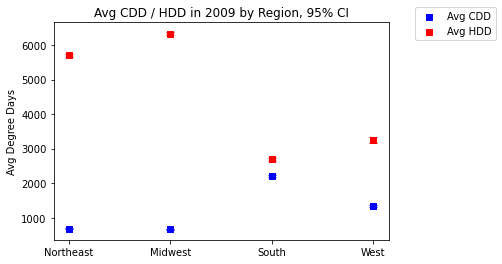

In [15]:
fig_09 = plt.figure()
ax09_1 = fig_09.add_subplot()

ax09_1.set_ylabel("Avg Degree Days")
ax09_1.set_title("Avg CDD / HDD in 2009 by Region, 95% CI")

bars = ax09_1.scatter(
    x=table_df_09["Region"],
    y=table_df_09["Avg Cooling Degree Days"],
    marker= "s",
    color="blue",
    label="Avg CDD"
    )

bars2 = ax09_1.scatter(
    x=table_df_09["Region"],
    y=table_df_09["Avg Heating Degree Days"],
    marker= "s",
    color="red",
    label= "Avg HDD"
    )

fig_09.legend(bbox_to_anchor = (0.95, 0.95), loc = "upper left")

_= plt.errorbar(
    data=table_df_09,
    x = "Region",
    y = "Avg Cooling Degree Days",
    fmt="None",
    yerr = "SE Cooling Degree Days",
    ecolor = "blue",
    capsize = 4
    )

_= plt.errorbar(
    data=table_df_09,
    x = "Region",
    y = "Avg Heating Degree Days",
    fmt="None",
    yerr = "SE Heating Degree Days",
    ecolor = "red",
    capsize = 4
    )

Shown above is a plot of the 2009 estimated HDD / CDD by region; the
large number of replicate weights creates very narrow confidence intervals.

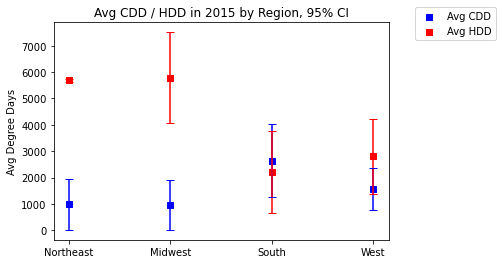

In [16]:
fig_15 = plt.figure()
ax15 = fig_15.add_subplot()

ax15.set_ylabel("Avg Degree Days")
ax15.set_title("Avg CDD / HDD in 2015 by Region, 95% CI")

bars3 = ax15.scatter(
    x=table_df_15["Region"],
    y=table_df_15["Avg Cooling Degree Days"],
    marker= "s",
    color="blue",
    label="Avg CDD"
    )

bars4 = ax15.scatter(
    x=table_df_15["Region"],
    y=table_df_15["Avg Heating Degree Days"],
    marker= "s",
    color="red",
    label="Avg HDD"
    )

fig_15.legend(bbox_to_anchor = (0.95, 0.95), loc = "upper left")

_= plt.errorbar(
    data=table_df_15,
    x = "Region",
    y = "Avg Cooling Degree Days",
    fmt="None",
    yerr = "SE Cooling Degree Days",
    ecolor = "blue",
    capsize = 4
    )

_= plt.errorbar(
    data=table_df_15,
    x = "Region",
    y = "Avg Heating Degree Days",
    fmt="None",
    yerr = "SE Heating Degree Days",
    ecolor = "red",
    capsize = 4
    )
# _

# As the 2015 data has fewer replicate weights, the confidence intervals are
# considerably larger

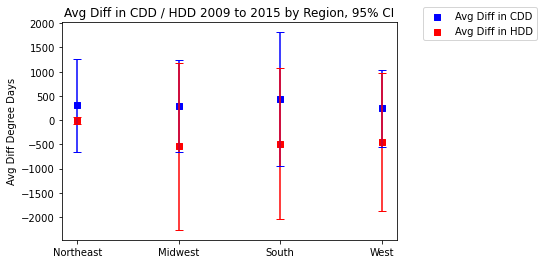

In [17]:
fig_diff = plt.figure()

axd = fig_diff.add_subplot()
axd.set_ylabel("Avg Diff Degree Days")
axd.set_title("Avg Diff in CDD / HDD 2009 to 2015 by Region, 95% CI")

bars5 = axd.scatter(
    x=table_df_diff["Region"],
    y=table_df_diff["Avg Cooling Degree Days"],
    marker= "s",
    color="blue",
    label="Avg Diff in CDD"
    )

bars6 = axd.scatter(
    x=table_df_diff["Region"],
    y=table_df_diff["Avg Heating Degree Days"],
    marker= "s",
    color="red",
    label="Avg Diff in HDD"
    )

fig_diff.legend(bbox_to_anchor = (0.95, 0.95), loc = "upper left")

_= plt.errorbar(
    data=table_df_diff,
    x = "Region",
    y = "Avg Cooling Degree Days",
    fmt="None",
    yerr = "SE Cooling Degree Days",
    ecolor = "blue",
    capsize = 4
    )

_= plt.errorbar(
    data=table_df_diff,
    x = "Region",
    y = "Avg Heating Degree Days",
    fmt="None",
    yerr = "SE Heating Degree Days",
    ecolor = "red",
    capsize = 4
    )

Because the variance is additive for the difference between two independent
variables, the confidence intervals for the difference in CDD / HDD from 
2009 to 2015 are the largest we've seen yet.